# Training FSRS on simulated data

Requirement: fsrs-optimizer >= 5.4.1

In [1]:
import numpy as np
import pandas as pd
from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0.4636,
    0.6048,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer()
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(verbose=False)
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 7


sample size: 273


  0%|          | 0/273 [00:00<?, ?it/s]

loss before: 0.3183, loss after: 0.2817


/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


RMSE(bins): 0.0504
AUC: 0.6906
1.1596 -> 2.1049: SMAPE=57.9139%
1.7974 -> 2.6016: SMAPE=36.5629%
13.1205 -> 3.1307: SMAPE=122.9423%
49.3729 -> 3.5277: SMAPE=173.3258%
7.2303 -> 7.3108: SMAPE=1.1072%
0.5081 -> 0.5165: SMAPE=1.6397%
1.5371 -> 1.3401: SMAPE=13.6939%
0.001 -> 0.1249: SMAPE=196.8229%
1.5052 -> 1.4316: SMAPE=5.0123%
0.1261 -> 0.2388: SMAPE=61.7703%
0.9735 -> 0.9051: SMAPE=7.2820%
1.8924 -> 1.8274: SMAPE=3.4948%
0.1486 -> 0.2217: SMAPE=39.4815%
0.2407 -> 0.1818: SMAPE=27.8817%
2.1937 -> 2.2004: SMAPE=0.3050%
0.1518 -> 0.1134: SMAPE=28.9593%
3.0699 -> 3.1099: SMAPE=1.2945%
0.4636 -> 0.5166: SMAPE=10.8141%
0.6048 -> 0.6621: SMAPE=9.0457%
Avg. SMAPE: 42.0710%
loss before: 0.3183, loss after: 0.2831
RMSE(bins): 0.0479
AUC: 0.6531
--------------------------------
learn_span: 15


/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


sample size: 870


  0%|          | 0/870 [00:00<?, ?it/s]

loss before: 0.3599, loss after: 0.3271
RMSE(bins): 0.0455
AUC: 0.6767
1.1596 -> 1.3889: SMAPE=17.9949%
1.7974 -> 1.6132: SMAPE=10.8016%
13.1205 -> 12.6419: SMAPE=3.7155%
49.3729 -> 73.1421: SMAPE=38.8021%
7.2303 -> 7.3096: SMAPE=1.0908%
0.5081 -> 0.4028: SMAPE=23.1200%
1.5371 -> 1.5756: SMAPE=2.4737%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4336: SMAPE=4.8727%
0.1261 -> 0.1539: SMAPE=19.8571%
0.9735 -> 0.9064: SMAPE=7.1387%
1.8924 -> 1.8126: SMAPE=4.3077%
0.1486 -> 0.2343: SMAPE=44.7636%
0.2407 -> 0.1642: SMAPE=37.7871%
2.1937 -> 2.1586: SMAPE=1.6129%
0.1518 -> 0.2068: SMAPE=30.6748%
3.0699 -> 2.8919: SMAPE=5.9714%
0.4636 -> 0.4182: SMAPE=10.2971%
0.6048 -> 0.5637: SMAPE=7.0347%
Avg. SMAPE: 14.3325%
loss before: 0.3599, loss after: 0.3298
RMSE(bins): 0.0540
AUC: 0.6421
--------------------------------
learn_span: 30


sample size: 2229


  0%|          | 0/2229 [00:00<?, ?it/s]

loss before: 0.3624, loss after: 0.3306
RMSE(bins): 0.0310
AUC: 0.6026
1.1596 -> 1.3496: SMAPE=15.1443%
1.7974 -> 1.8463: SMAPE=2.6841%
13.1205 -> 11.3749: SMAPE=14.2525%
49.3729 -> 54.6902: SMAPE=10.2194%
7.2303 -> 7.2618: SMAPE=0.4347%
0.5081 -> 0.7123: SMAPE=33.4644%
1.5371 -> 1.5907: SMAPE=3.4273%
0.001 -> 0.0014: SMAPE=33.3333%
1.5052 -> 1.4758: SMAPE=1.9725%
0.1261 -> 0.1526: SMAPE=19.0169%
0.9735 -> 0.9527: SMAPE=2.1597%
1.8924 -> 1.8948: SMAPE=0.1267%
0.1486 -> 0.1497: SMAPE=0.7375%
0.2407 -> 0.2572: SMAPE=6.6278%
2.1937 -> 2.2656: SMAPE=3.2247%
0.1518 -> 0.0126: SMAPE=169.3431%
3.0699 -> 3.1879: SMAPE=3.7713%
0.4636 -> 0.6874: SMAPE=38.8879%
0.6048 -> 0.8317: SMAPE=31.5907%
Avg. SMAPE: 20.5484%
loss before: 0.3624, loss after: 0.3318
RMSE(bins): 0.0319
AUC: 0.5830
--------------------------------
learn_span: 60


sample size: 5304


  0%|          | 0/5304 [00:00<?, ?it/s]

loss before: 0.3515, loss after: 0.3231
RMSE(bins): 0.0237
AUC: 0.5824
1.1596 -> 1.2926: SMAPE=10.8474%
1.7974 -> 1.7538: SMAPE=2.4555%
13.1205 -> 12.6566: SMAPE=3.5993%
49.3729 -> 30.328: SMAPE=47.7909%
7.2303 -> 7.0197: SMAPE=2.9558%
0.5081 -> 0.2843: SMAPE=56.4866%
1.5371 -> 1.7265: SMAPE=11.6068%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.6027: SMAPE=6.2743%
0.1261 -> 0.2309: SMAPE=58.7115%
0.9735 -> 1.1003: SMAPE=12.2288%
1.8924 -> 1.8724: SMAPE=1.0625%
0.1486 -> 0.1874: SMAPE=23.0952%
0.2407 -> 0.2246: SMAPE=6.9203%
2.1937 -> 2.3197: SMAPE=5.5834%
0.1518 -> 0.1101: SMAPE=31.8442%
3.0699 -> 3.1881: SMAPE=3.7776%
0.4636 -> 0.3829: SMAPE=19.0667%
0.6048 -> 0.5247: SMAPE=14.1833%
Avg. SMAPE: 16.7626%
loss before: 0.3515, loss after: 0.3242
RMSE(bins): 0.0249
AUC: 0.5625
--------------------------------
learn_span: 120


sample size: 11821


  0%|          | 0/11821 [00:00<?, ?it/s]

loss before: 0.3442, loss after: 0.3239
RMSE(bins): 0.0215
AUC: 0.5553
1.1596 -> 1.4941: SMAPE=25.2101%
1.7974 -> 2.1341: SMAPE=17.1283%
13.1205 -> 11.4048: SMAPE=13.9913%
49.3729 -> 36.5577: SMAPE=29.8269%
7.2303 -> 7.0669: SMAPE=2.2858%
0.5081 -> 0.5778: SMAPE=12.8373%
1.5371 -> 1.6347: SMAPE=6.1542%
0.001 -> 0.0102: SMAPE=164.2857%
1.5052 -> 1.4797: SMAPE=1.7086%
0.1261 -> 0.1818: SMAPE=36.1806%
0.9735 -> 0.9813: SMAPE=0.7980%
1.8924 -> 1.8944: SMAPE=0.1056%
0.1486 -> 0.1883: SMAPE=23.5678%
0.2407 -> 0.2658: SMAPE=9.9112%
2.1937 -> 2.4698: SMAPE=11.8409%
0.1518 -> 0.1263: SMAPE=18.3387%
3.0699 -> 3.25: SMAPE=5.6995%
0.4636 -> 0.4827: SMAPE=4.0368%
0.6048 -> 0.6311: SMAPE=4.2560%
Avg. SMAPE: 20.4296%
loss before: 0.3442, loss after: 0.3244
RMSE(bins): 0.0228
AUC: 0.5406
--------------------------------
learn_span: 240


sample size: 25427


  0%|          | 0/25427 [00:00<?, ?it/s]

loss before: 0.3494, loss after: 0.3321
RMSE(bins): 0.0175
AUC: 0.5497
1.1596 -> 1.2596: SMAPE=8.2672%
1.7974 -> 1.7588: SMAPE=2.1709%
13.1205 -> 12.6176: SMAPE=3.9078%
49.3729 -> 45.0513: SMAPE=9.1536%
7.2303 -> 7.0959: SMAPE=1.8763%
0.5081 -> 0.2817: SMAPE=57.3310%
1.5371 -> 1.6242: SMAPE=5.5104%
0.001 -> 0.0011: SMAPE=9.5238%
1.5052 -> 1.4805: SMAPE=1.6546%
0.1261 -> 0.1043: SMAPE=18.9236%
0.9735 -> 1.0207: SMAPE=4.7337%
1.8924 -> 1.8637: SMAPE=1.5282%
0.1486 -> 0.1738: SMAPE=15.6328%
0.2407 -> 0.2443: SMAPE=1.4845%
2.1937 -> 2.349: SMAPE=6.8373%
0.1518 -> 0.1782: SMAPE=16.0000%
3.0699 -> 2.9742: SMAPE=3.1667%
0.4636 -> 0.7007: SMAPE=40.7283%
0.6048 -> 0.8307: SMAPE=31.4734%
Avg. SMAPE: 12.6265%
loss before: 0.3494, loss after: 0.3322
RMSE(bins): 0.0178
AUC: 0.5444
--------------------------------
learn_span: 480


sample size: 54307


  0%|          | 0/54307 [00:00<?, ?it/s]

loss before: 0.3382, loss after: 0.3241
RMSE(bins): 0.0138
AUC: 0.5528
1.1596 -> 1.4258: SMAPE=20.5926%
1.7974 -> 2.0: SMAPE=10.6705%
13.1205 -> 13.0383: SMAPE=0.6285%
49.3729 -> 51.3132: SMAPE=3.8542%
7.2303 -> 7.0575: SMAPE=2.4188%
0.5081 -> 0.3679: SMAPE=32.0091%
1.5371 -> 1.2902: SMAPE=17.4654%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4073: SMAPE=6.7227%
0.1261 -> 0.0834: SMAPE=40.7637%
0.9735 -> 1.0087: SMAPE=3.5516%
1.8924 -> 1.8262: SMAPE=3.5605%
0.1486 -> 0.23: SMAPE=43.0005%
0.2407 -> 0.2788: SMAPE=14.6679%
2.1937 -> 2.3512: SMAPE=6.9308%
0.1518 -> 0.1433: SMAPE=5.7608%
3.0699 -> 3.0586: SMAPE=0.3688%
0.4636 -> 0.5215: SMAPE=11.7552%
0.6048 -> 0.6334: SMAPE=4.6196%
Avg. SMAPE: 12.0706%
loss before: 0.3382, loss after: 0.3243
RMSE(bins): 0.0147
AUC: 0.5455
--------------------------------
learn_span: 960


sample size: 102426


  0%|          | 0/102426 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3287
RMSE(bins): 0.0113
AUC: 0.5401
1.1596 -> 1.254: SMAPE=7.8223%
1.7974 -> 1.8752: SMAPE=4.2368%
13.1205 -> 13.0776: SMAPE=0.3275%
49.3729 -> 52.1998: SMAPE=5.5663%
7.2303 -> 6.9239: SMAPE=4.3295%
0.5081 -> 0.4396: SMAPE=14.4561%
1.5371 -> 1.565: SMAPE=1.7988%
0.001 -> 0.0018: SMAPE=57.1429%
1.5052 -> 1.3785: SMAPE=8.7873%
0.1261 -> 0.1231: SMAPE=2.4077%
0.9735 -> 1.1332: SMAPE=15.1612%
1.8924 -> 1.6129: SMAPE=15.9473%
0.1486 -> 0.2119: SMAPE=35.1179%
0.2407 -> 0.2778: SMAPE=14.3105%
2.1937 -> 3.1652: SMAPE=36.2574%
0.1518 -> 0.11: SMAPE=31.9328%
3.0699 -> 2.7704: SMAPE=10.2563%
0.4636 -> 0.5208: SMAPE=11.6213%
0.6048 -> 0.5964: SMAPE=1.3986%
Avg. SMAPE: 14.6778%
loss before: 0.3395, loss after: 0.3287
RMSE(bins): 0.0114
AUC: 0.5370
--------------------------------


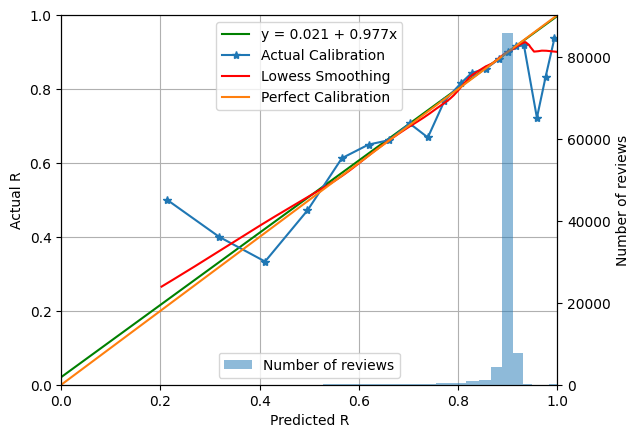

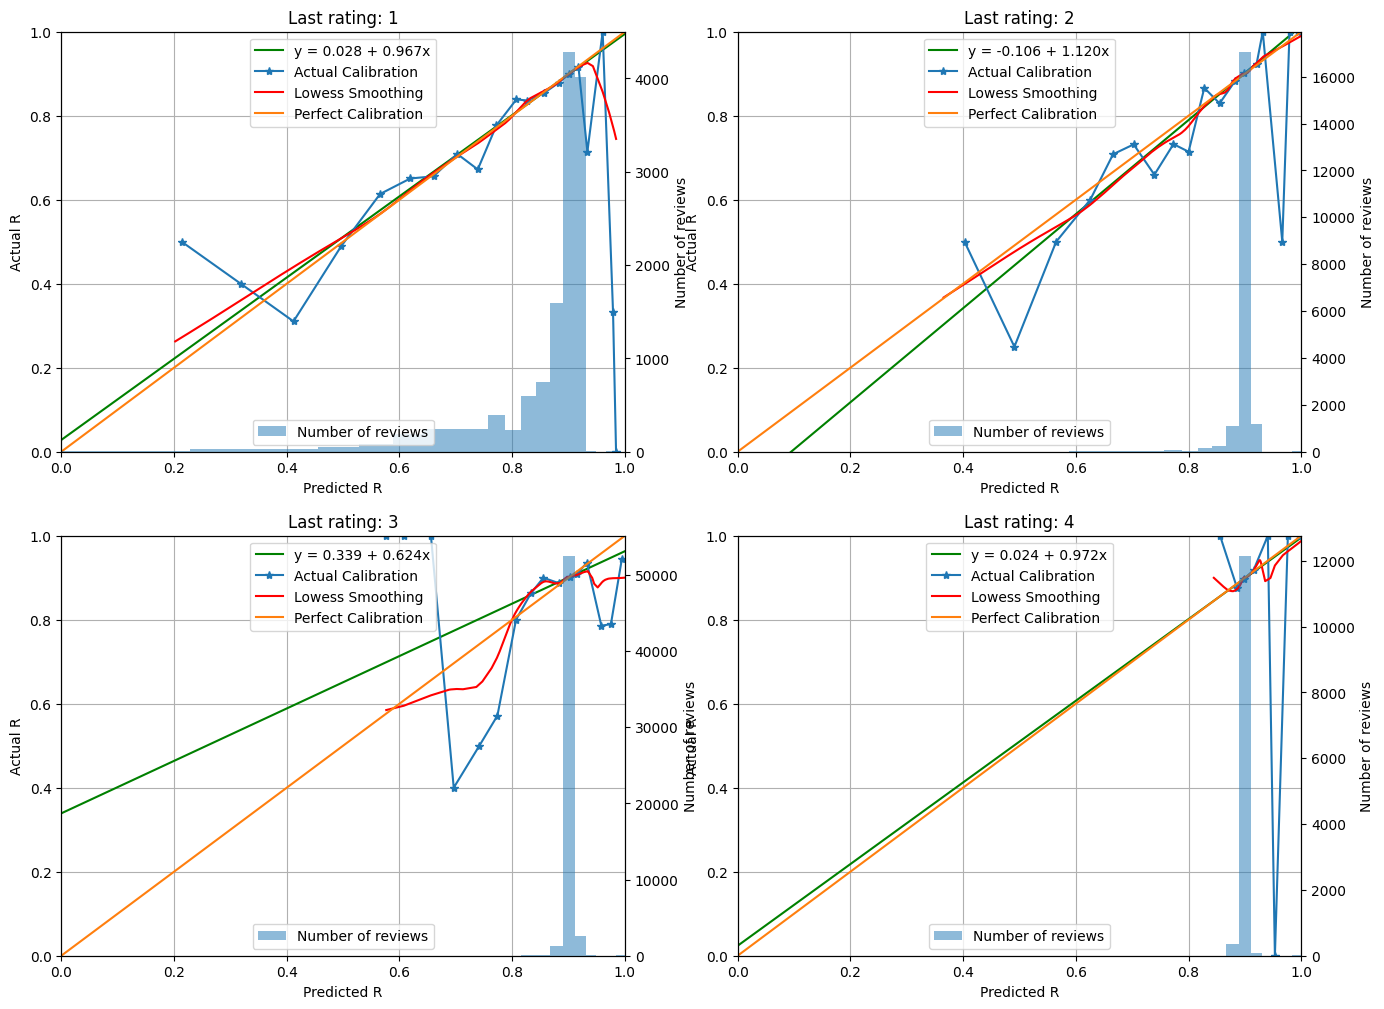

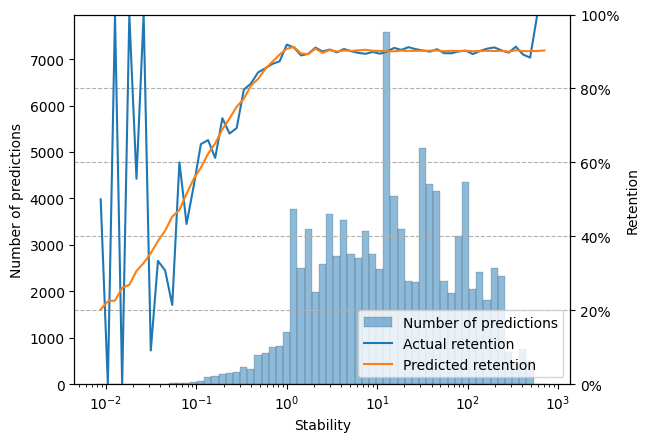

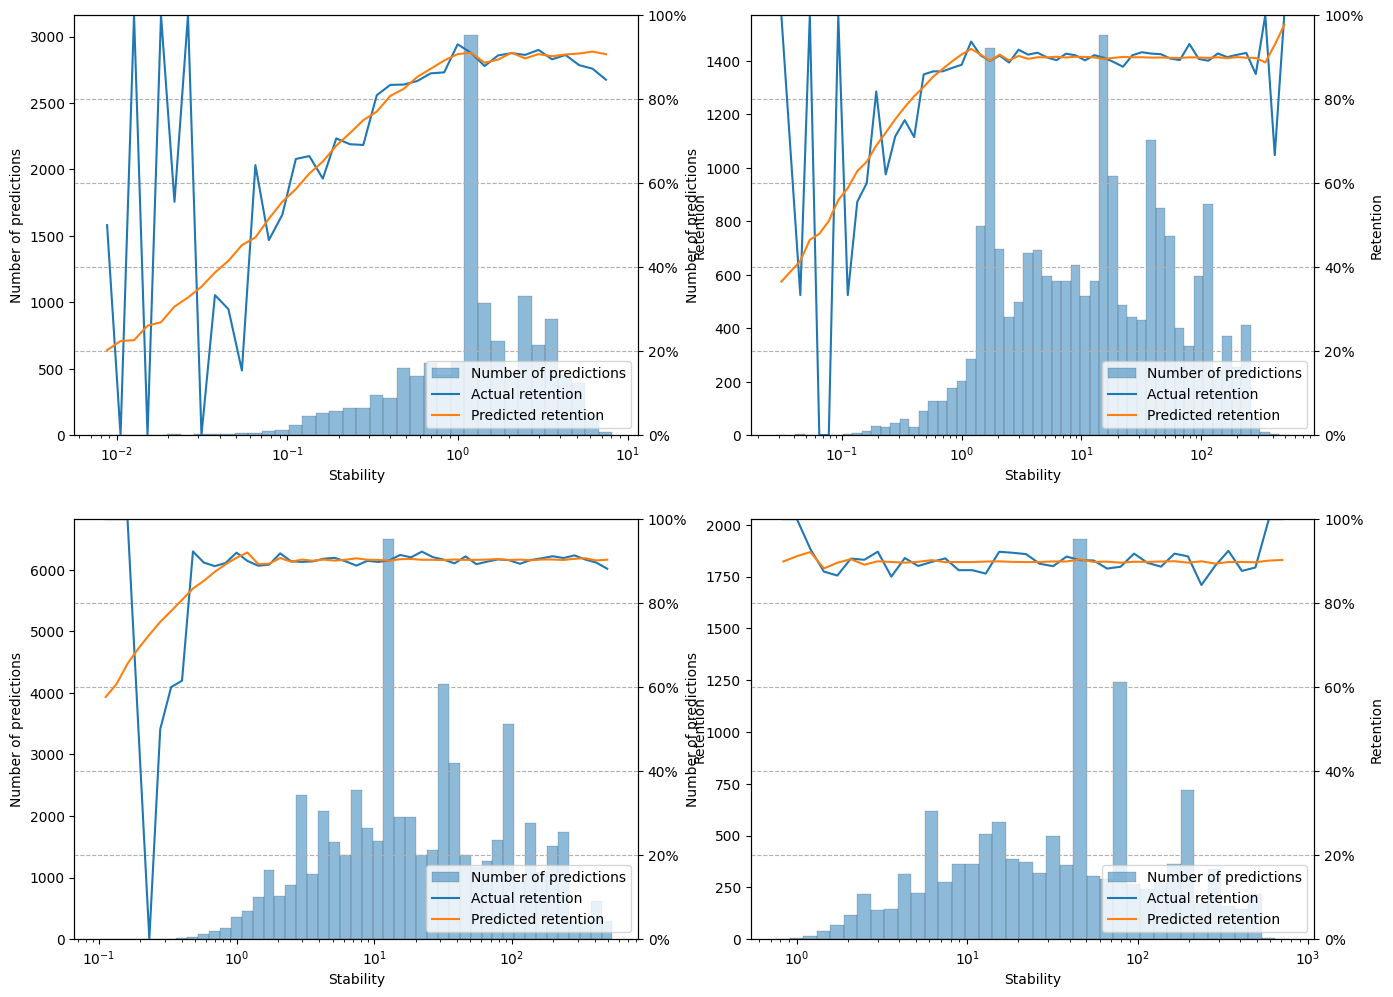

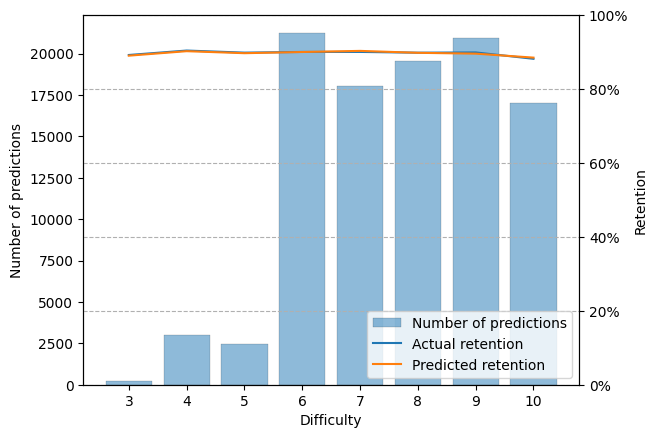

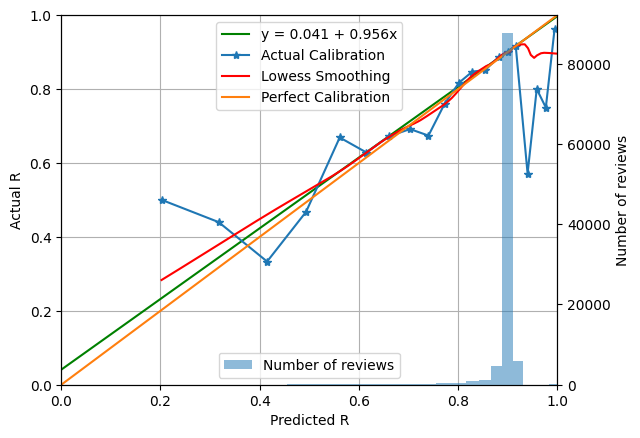

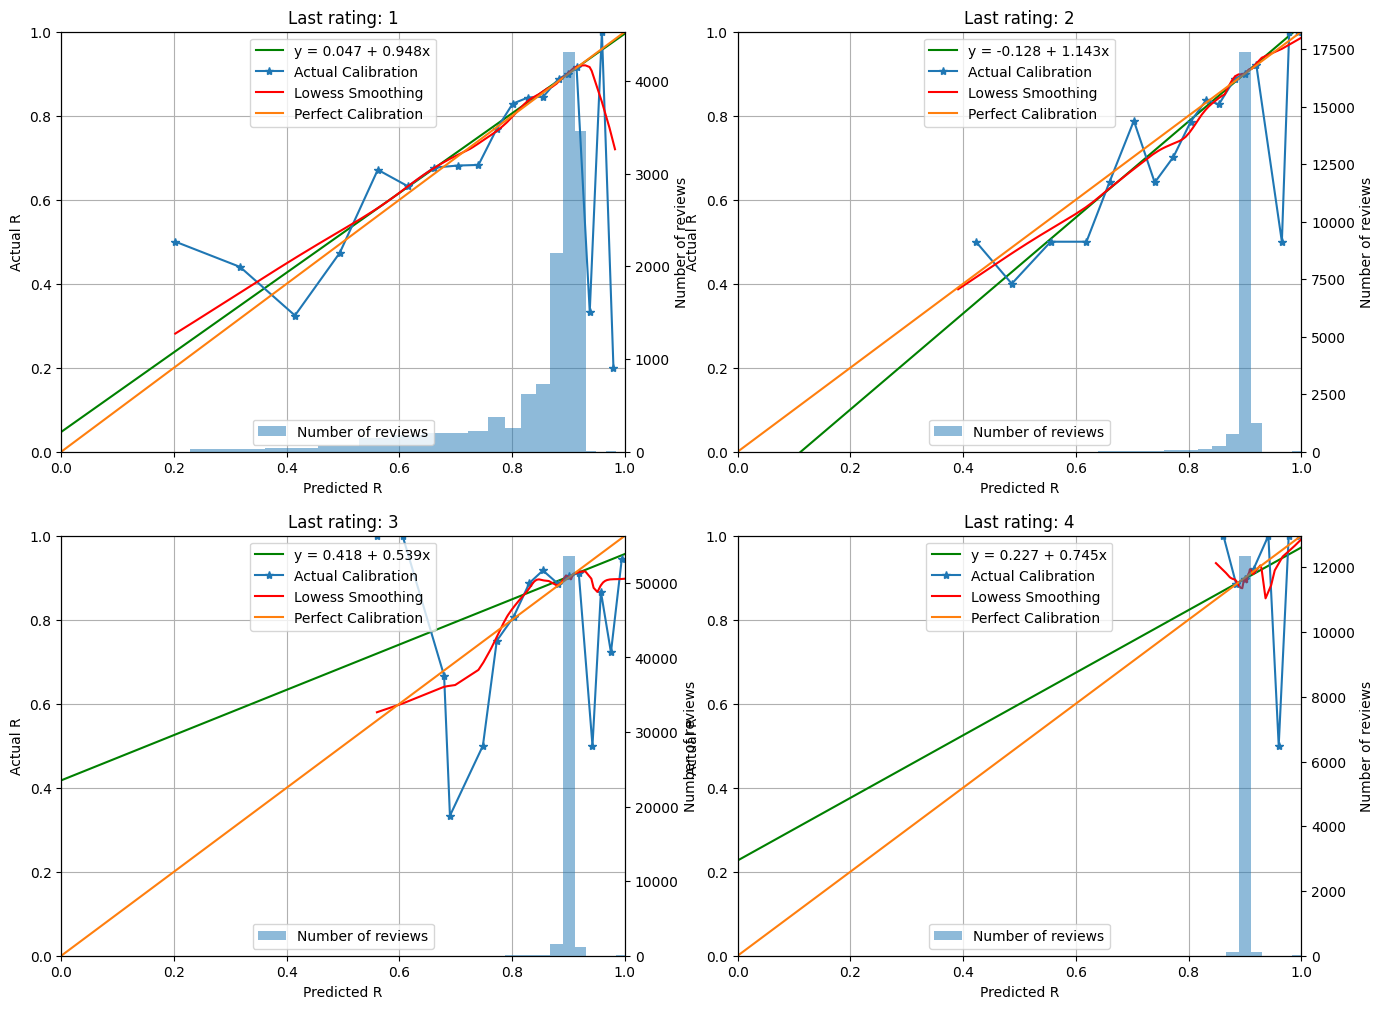

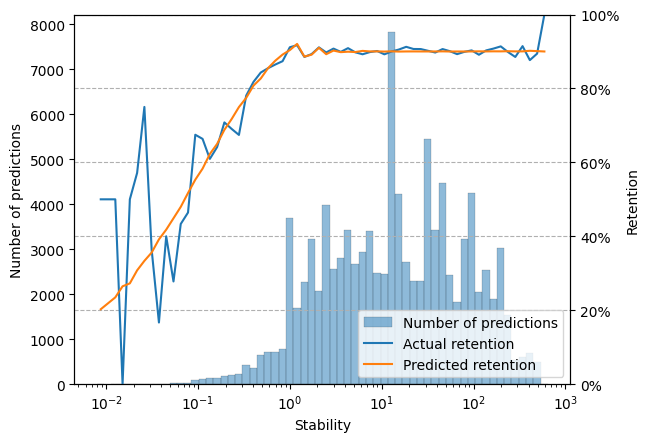

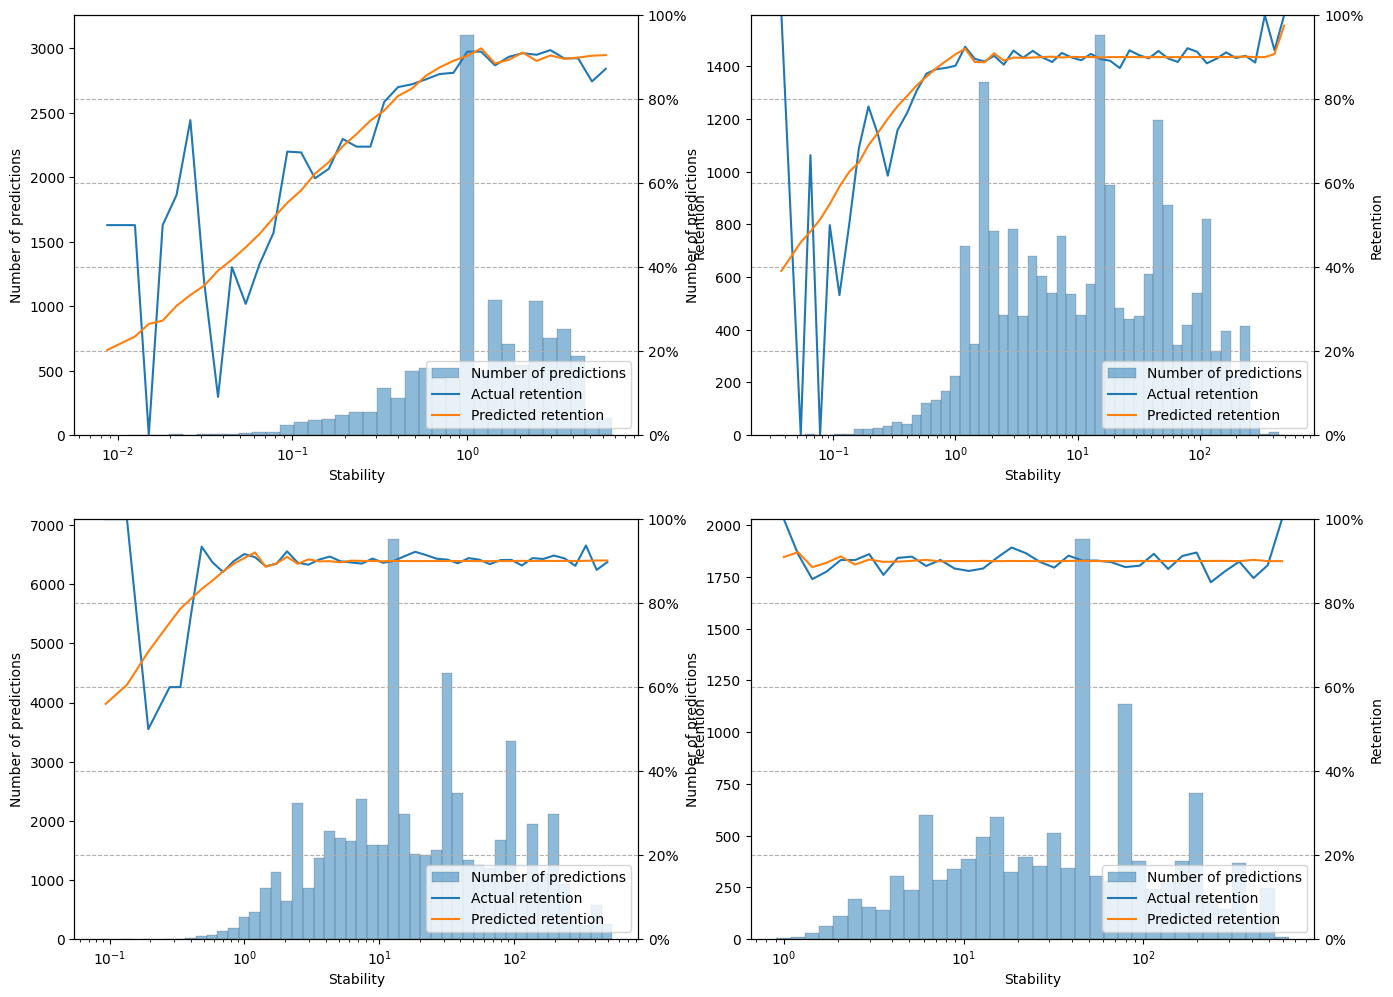

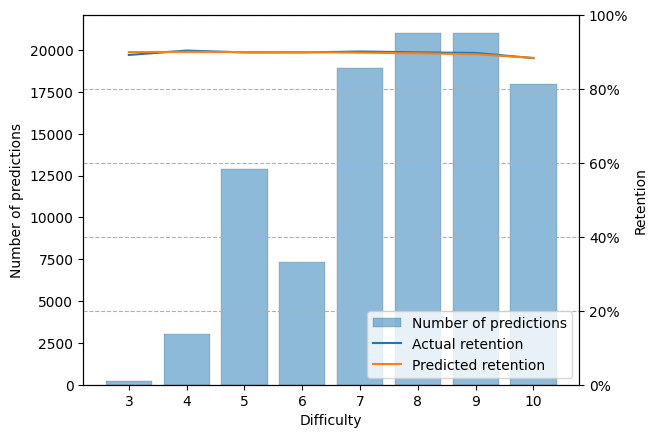

In [4]:
learn_span_list = [7, 15, 30, 60, 120, 240, 480, 960]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

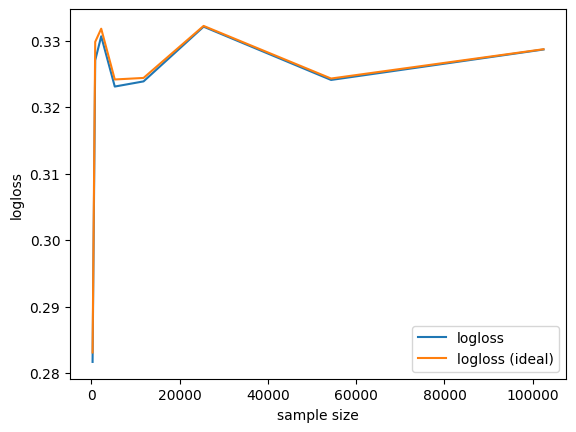

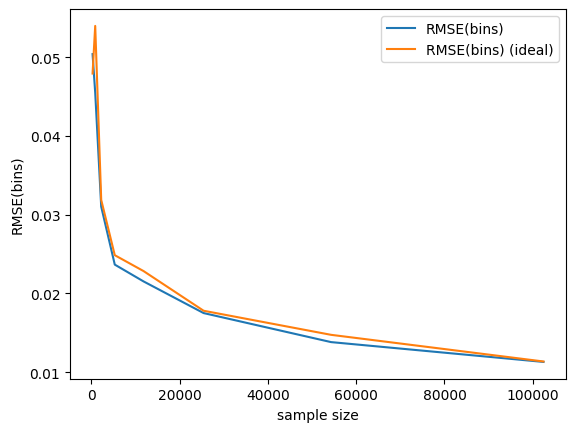

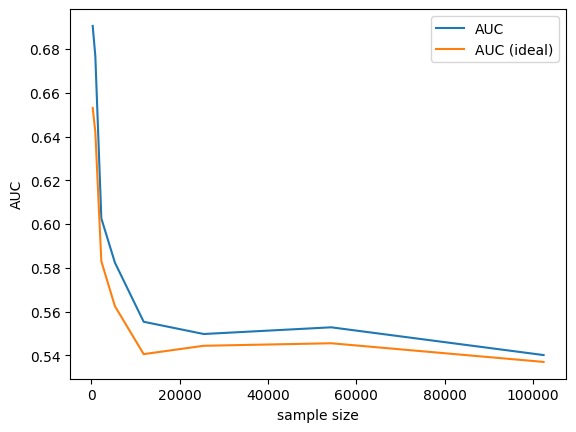

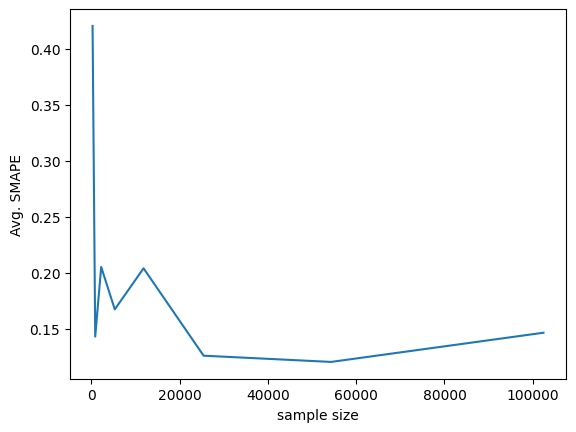

In [6]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()
